In [ ]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import json

from acoustic_loc.utils import (
    load_scene_from_h5,
    load_scene_metadata,
    find_peaks_on_map, 
)

In [ ]:
h5_path = Path("../data/processed/train.h5")
with h5py.File(h5_path, "r") as f:
    print(list(f.keys()))
    for name in ["pressure_real", "pressure_imag", "source_maps", "sample_ids"]:
        print(name, f[name].shape, f[name].dtype)

['pressure_imag', 'pressure_real', 'sample_ids', 'source_maps']
pressure_real (8000, 256, 256) float32
pressure_imag (8000, 256, 256) float32
source_maps (8000, 256, 256) float32
sample_ids (8000,) int64


Сэмпл 5004 найден в 'train.h5' по индексу 6445.


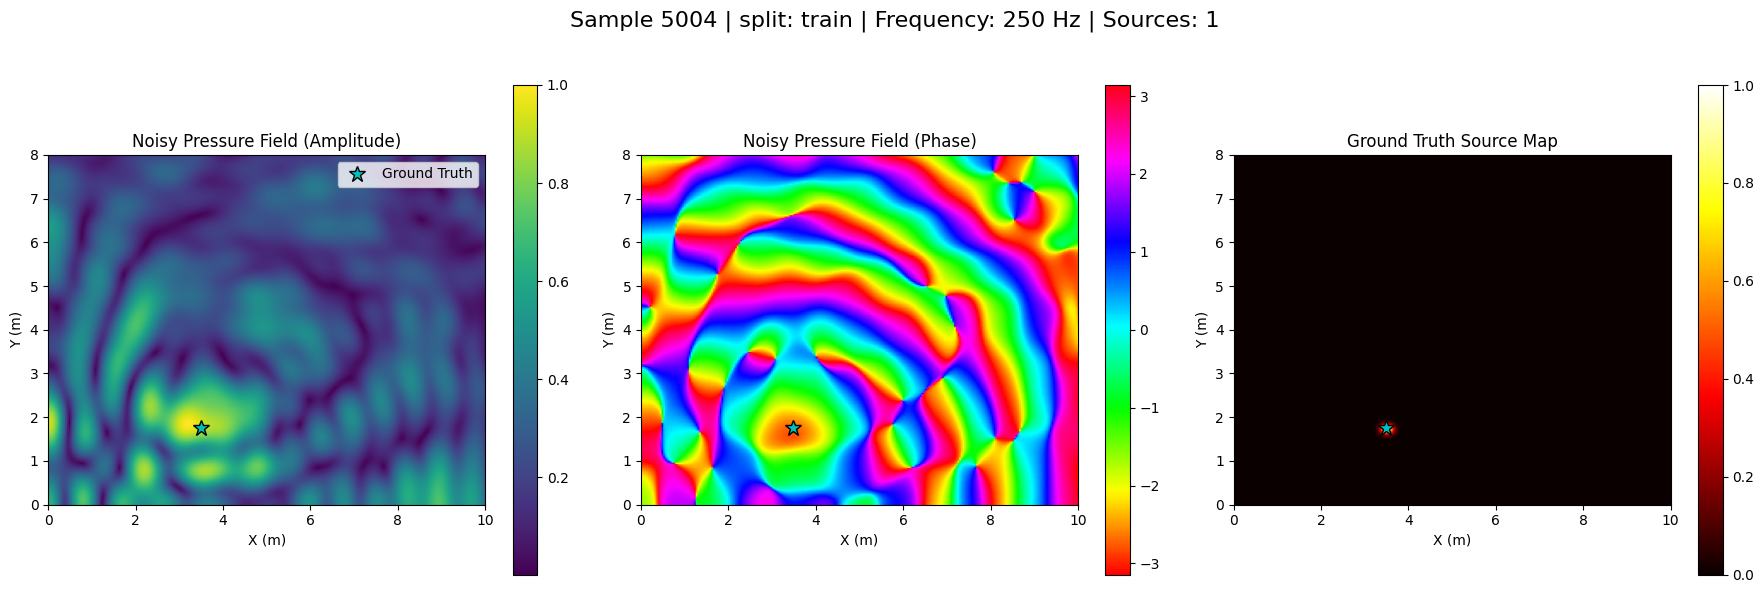

In [20]:
from acoustic_loc.utils import visualize_dataset_sample

PROJECT_DIR = "../."  # или полный путь

visualize_dataset_sample(PROJECT_DIR, sample_id=5004)


In [12]:
import glob

json_files = glob.glob("../data/metadata/json/sample_*_info.json")
print("JSON files:", len(json_files))

# посмотрим несколько сцен
for path in json_files[:3]:
    with open(path, "r", encoding="utf-8") as f:
        meta = json.load(f)
    print(
        Path(path).name,
        "freq:", meta["frequency"],
        "n_sources:", len(meta["sources"]),
        "first types:", [s["type"] for s in meta["sources"]][:3],
    )


JSON files: 10000
sample_000001_info.json freq: 8000 n_sources: 4 first types: ['music', 'machinery', 'impact']
sample_000002_info.json freq: 250 n_sources: 10 first types: ['music', 'music', 'impact']
sample_000003_info.json freq: 4000 n_sources: 8 first types: ['impact', 'impact', 'impact']


In [13]:
from collections import Counter

counts = Counter()
for path in json_files:
    with open(path, "r", encoding="utf-8") as f:
        meta = json.load(f)
    counts[len(meta["sources"])] += 1

counts


Counter({6: 1027,
         1: 1016,
         8: 1015,
         10: 1013,
         3: 1006,
         2: 998,
         4: 988,
         7: 986,
         9: 983,
         5: 968})

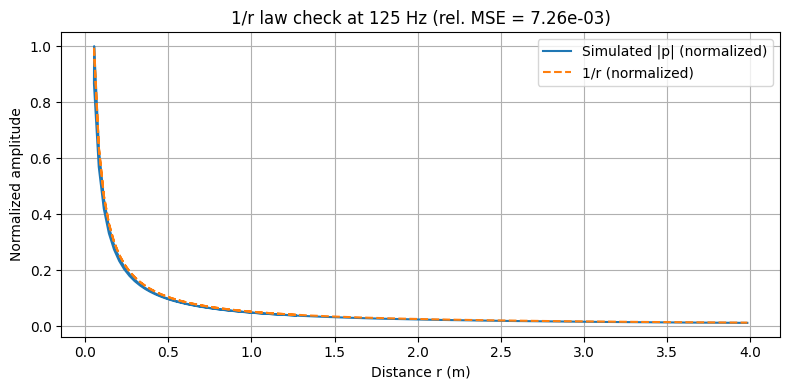

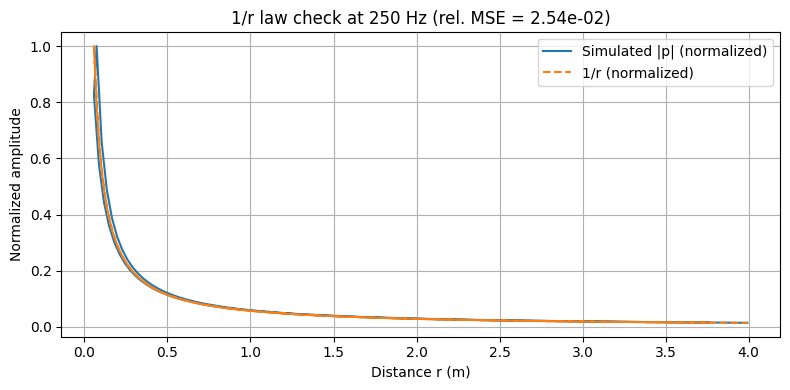

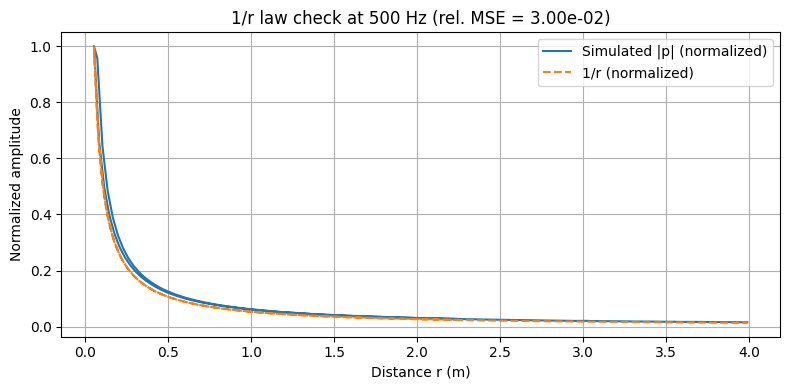

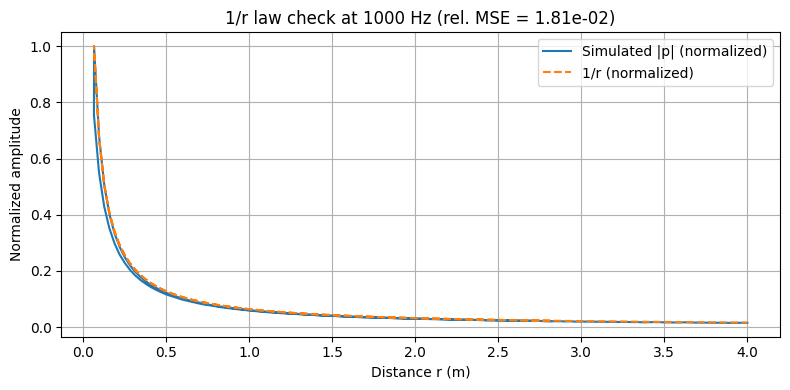

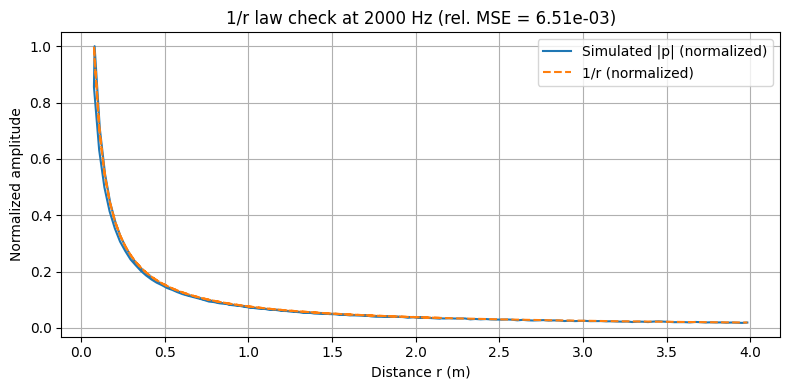

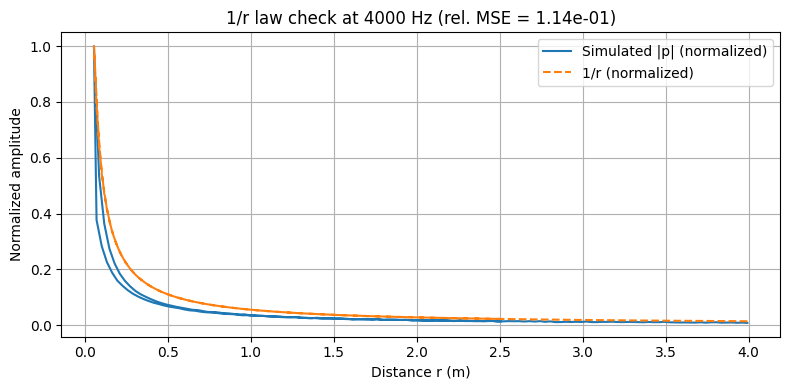

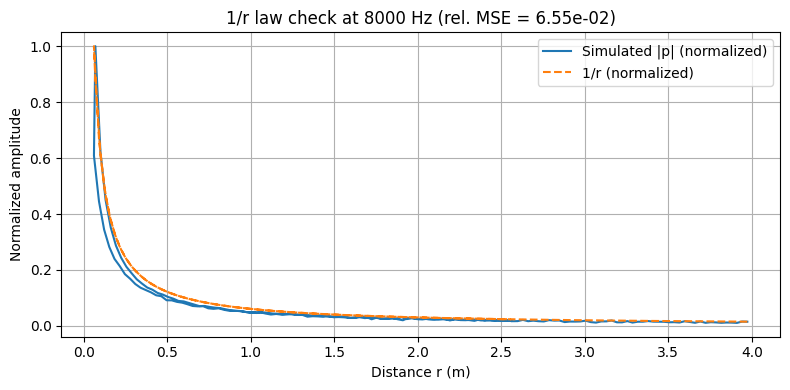

{'frequency': 8000.0,
 'spl_db': 80.0,
 'r': array([3.9732107 , 3.94196098, 3.91071139, 3.87946169, 3.84821211,
        3.81696241, 3.78571284, 3.75446316, 3.72321361, 3.69196393,
        3.6607144 , 3.62946473, 3.59821521, 3.56696556, 3.53571606,
        3.50446642, 3.47321693, 3.44196731, 3.41071784, 3.37946823,
        3.34821878, 3.31696919, 3.28571976, 3.25447019, 3.22322077,
        3.19197122, 3.16072183, 3.12947229, 3.09822292, 3.06697341,
        3.03572407, 3.00447458, 2.97322526, 2.94197579, 2.9107265 ,
        2.87947706, 2.8482278 , 2.81697847, 2.78572915, 2.75447985,
        2.72323057, 2.6919813 , 2.66073205, 2.62948282, 2.59823361,
        2.56698441, 2.53573524, 2.50448608, 2.47323695, 2.44198784,
        2.41073875, 2.37948969, 2.34824065, 2.31699164, 2.28574265,
        2.2544937 , 2.22324477, 2.19199587, 2.16074701, 2.12949817,
        2.09824938, 2.06700062, 2.03575189, 2.00450321, 1.97325457,
        1.94200597, 1.91075742, 1.87950892, 1.84826046, 1.81701206,
    

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from acoustic_loc.config import (
    RoomConfig,
    GridConfig,
    SourcesConfig,
    AcousticsConfig,
    DatasetConfig,
    FullSimConfig,
)
from acoustic_loc.simulator import AcousticSimulator


def check_inverse_r_law(
    frequency: float = 1000.0,
    spl_db: float = 80.0,
    r_min: float = 0.05,
    max_offset_m: float = 4.0,
    plot: bool = True,
) -> dict:
    """
    Проверка того, что реализованный симулятор воспроизводит зависимость
    амплитуды от расстояния, близкую к теоретическому закону 1/r
    в свободном пространстве.

    Допущения:
      - Один точечный источник в однородной среде.
      - Без отражений от стен/потолка (max_image_order = 0).
      - Без дополнительного затухания в воздухе и шума.

    Параметры
    ---------
    frequency : float
        Частота гармонического источника (Гц).
    spl_db : float
        Уровень звукового давления источника (дБ SPL) возле источника.
    r_min : float
        Минимальное расстояние при сравнении с 1/r, м (чтобы избежать сингулярности).
    max_offset_m : float
        Максимальное расстояние по срезу, на котором оценивается ошибка (м).
    plot : bool
        Если True, строится диагностический график.

    Возвращает
    ----------
    results : dict
        {
            "frequency": ...,
            "spl_db": ...,
            "r": np.ndarray,          # радиусы вдоль среза
            "p_norm": np.ndarray,     # нормированная амплитуда симулятора
            "theory_norm": np.ndarray,# нормированный 1/r
            "rel_mse": float,         # относительная MSE между кривыми
        }
    """

    # ------------------------------
    # 1. Конфигурация "идеальной" сцены
    # ------------------------------
    room = RoomConfig(Lx=10.0, Ly=8.0, Lz=3.0, z_meas=1.5)
    grid = GridConfig(nx=256, ny=256)

    # один тестовый источник, фиксированный SPL и высота
    sources = SourcesConfig(
        n_min=1,
        n_max=1,
        margin_xy=0.3,
        z_min=1.5,
        z_max=1.5,
        types=["test"],
        spl_ranges={"test": [spl_db, spl_db]},
        source_map_sigma_m=0.1,
    )

    # акустика: без поглощения и шума, одна частота
    acoustics = AcousticsConfig(
        c=343.0,
        freqs=[frequency],
        alpha=0.0,
        floor_absorption=0.0,
        snr_db=None,
        ceiling_absorption=0.0,
        wall_absorption_x=0.0,
        wall_absorption_y=0.0,
        concrete_absorption_freq=None,
    )

    dataset = DatasetConfig(
        n_train=1,
        n_val=0,
        n_test=0,
        h5_out_dir="",
        json_out_dir="",
        source_map_sigma_m=0.1,
    )

    cfg = FullSimConfig(
        room=room,
        grid=grid,
        sources=sources,
        acoustics=acoustics,
        dataset=dataset,
    )

    # ------------------------------
    # 2. Генерация сцены и выключение отражений
    # ------------------------------
    sim = AcousticSimulator(cfg)
    sim.max_image_order = 0  # только прямой путь, без image‑sources

    p_complex, s_map, meta = sim.generate_scene()
    p_mag = np.abs(p_complex)

    # ------------------------------
    # 3. Определение истинного положения источника
    # ------------------------------
    assert len(meta["sources"]) == 1, "Должен быть ровно один источник."

    src = meta["sources"][0]
    x_s = float(src["position"]["x"])
    y_s = float(src["position"]["y"])
    z_s = float(src["position"]["z"])

    # индекс строки по x, ближе всего к x_s
    ix_src = int(round(x_s / sim.dx))
    ix_src = np.clip(ix_src, 0, sim.grid_x - 1)

    # координаты по y для среза (ось 1)
    H, W = p_mag.shape
    y_coords = np.arange(W, dtype=np.float32) * sim.dy

    # ------------------------------
    # 4. Радиус r до каждой точки среза
    # ------------------------------
    # Геометрически: r^2 = (x - x_s)^2 + (y - y_s)^2 + (z_meas - z_s)^2
    x_coord_slice = ix_src * sim.dx
    dz = sim.measurement_height - z_s

    r = np.sqrt(
        (x_coord_slice - x_s) ** 2
        + (y_coords - y_s) ** 2
        + dz**2
    )

    # возьмём только участок r <= max_offset_m
    mask = r <= max_offset_m
    r_line = r[mask]
    p_line = p_mag[ix_src, :][mask]

    # отфильтруем r < r_min при сравнении с 1/r
    valid = r_line >= r_min
    r_valid = r_line[valid]
    p_valid = p_line[valid]

    # ------------------------------
    # 5. Нормировка и теоретическая кривая 1/r
    # ------------------------------
    p_norm = p_valid / p_valid.max()
    theory = 1.0 / r_valid
    theory_norm = theory / theory.max()

    # относительная среднеквадратичная ошибка
    rel_mse = float(
        np.mean((p_norm - theory_norm) ** 2) / np.mean(theory_norm**2)
    )

    # ------------------------------
    # 6. Визуализация (по желанию)
    # ------------------------------
    if plot:
        plt.figure(figsize=(8, 4))
        plt.plot(r_valid, p_norm, label="Simulated |p| (normalized)")
        plt.plot(r_valid, theory_norm, "--", label="1/r (normalized)")
        plt.xlabel("Distance r (m)")
        plt.ylabel("Normalized amplitude")
        plt.title(
            f"1/r law check at {frequency:.0f} Hz "
            f"(rel. MSE = {rel_mse:.2e})"
        )
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    return {
        "frequency": frequency,
        "spl_db": spl_db,
        "r": r_valid,
        "p_norm": p_norm,
        "theory_norm": theory_norm,
        "rel_mse": rel_mse,
    }

# [125, 250, 500, 1000, 2000, 4000, 8000]
check_inverse_r_law(
    frequency=125.0,
    spl_db=80.0,
    r_min=0.05,
    max_offset_m=4.0,
    plot=True,
)
check_inverse_r_law(
    frequency=250.0,
    spl_db=80.0,
    r_min=0.05,
    max_offset_m=4.0,
    plot=True,
)
check_inverse_r_law(
    frequency=500.0,
    spl_db=80.0,
    r_min=0.05,
    max_offset_m=4.0,
    plot=True,
)
check_inverse_r_law(
    frequency=1000.0,
    spl_db=80.0,
    r_min=0.05,
    max_offset_m=4.0,
    plot=True,
)
check_inverse_r_law(
    frequency=2000.0,
    spl_db=80.0,
    r_min=0.05,
    max_offset_m=4.0,
    plot=True,
)
check_inverse_r_law(
    frequency=4000.0,
    spl_db=80.0,
    r_min=0.05,
    max_offset_m=4.0,
    plot=True,
)
check_inverse_r_law(
    frequency=8000.0,
    spl_db=80.0,
    r_min=0.05,
    max_offset_m=4.0,
    plot=True,
)


In [7]:
freqs = [125, 250, 500, 1000, 2000, 4000, 8000]
rows = []
for f in freqs:
    res = check_inverse_r_law(frequency=float(f), spl_db=80.0,
                              r_min=0.05, max_offset_m=4.0, plot=False)
    rows.append((f, res["rel_mse"]))

for f, e in rows:
    print(f"{f:4d} Hz  ->  rel. MSE = {e:.3e}")


 125 Hz  ->  rel. MSE = 4.414e-02
 250 Hz  ->  rel. MSE = 1.539e-02
 500 Hz  ->  rel. MSE = 1.405e-02
1000 Hz  ->  rel. MSE = 3.269e-02
2000 Hz  ->  rel. MSE = 5.519e-02
4000 Hz  ->  rel. MSE = 1.089e-01
8000 Hz  ->  rel. MSE = 7.989e-02


In [22]:
# Два источника вместо одного
sim.max_image_order = 0

# Хак: сгенерируем сцену дважды и руками сложим два источника
src1 = sim._generate_source(frequency=1000.0)
src2 = sim._generate_source(frequency=1000.0)

p1 = sim._compute_pressure_field([src1], frequency=1000.0)
p2 = sim._compute_pressure_field([src2], frequency=1000.0)
p12 = sim._compute_pressure_field([src1, src2], frequency=1000.0)

rel_mse = np.mean(np.abs(p12 - (p1 + p2))**2) / np.mean(np.abs(p12)**2)
print("Relative MSE (superposition check):", rel_mse)


Relative MSE (superposition check): 0.0


Сэмпл 1 найден в 'train.h5' по индексу 6923.


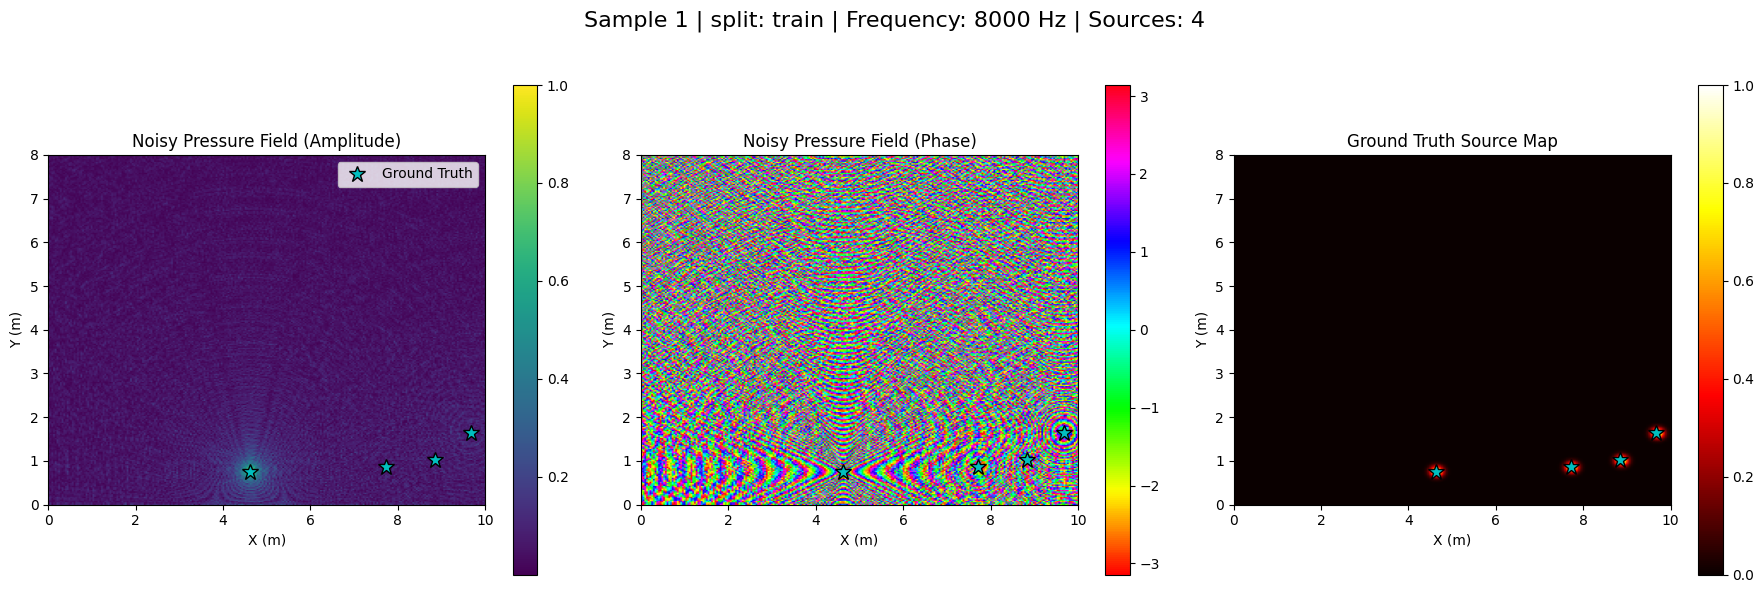

Сэмпл 2 найден в 'train.h5' по индексу 2458.


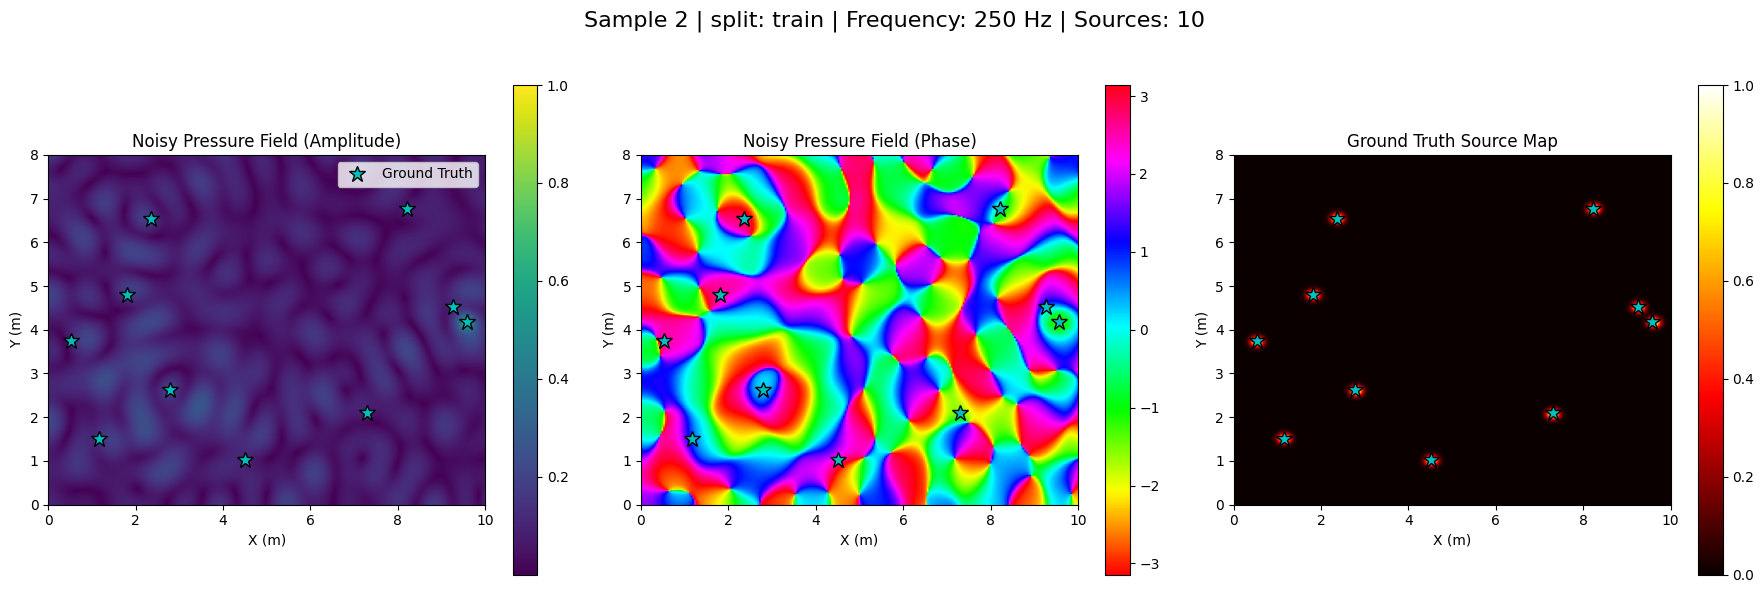

Сэмпл 100 найден в 'train.h5' по индексу 2543.


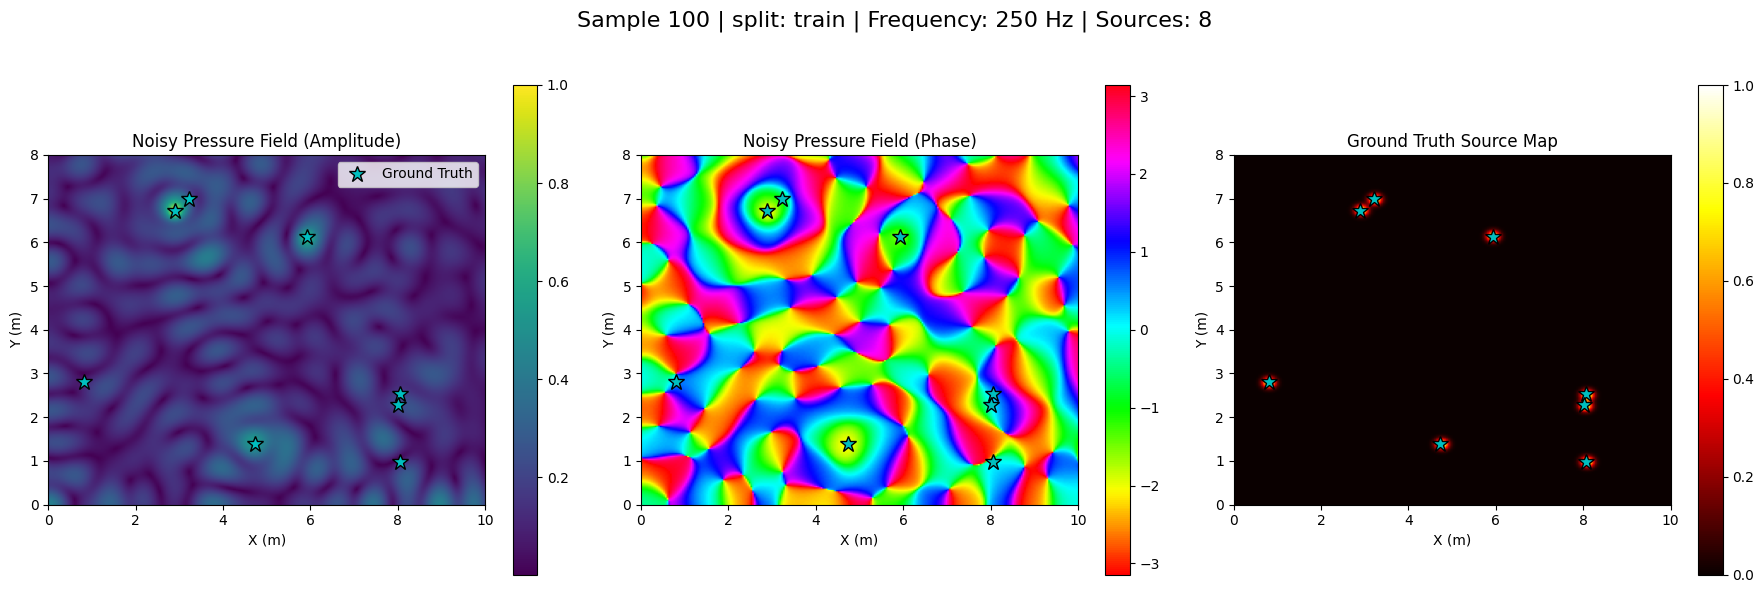

Сэмпл 500 найден в 'train.h5' по индексу 2994.


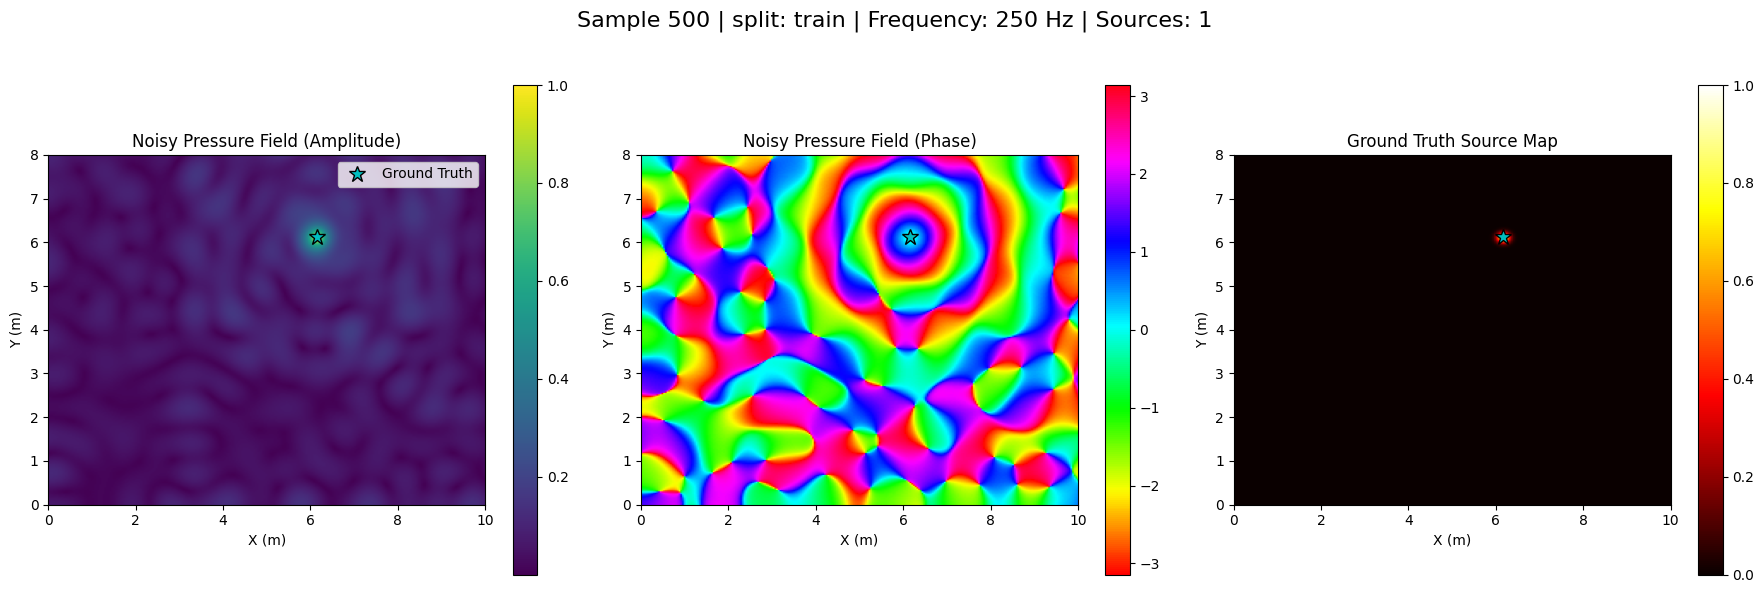

Сэмпл 999 найден в 'train.h5' по индексу 1840.


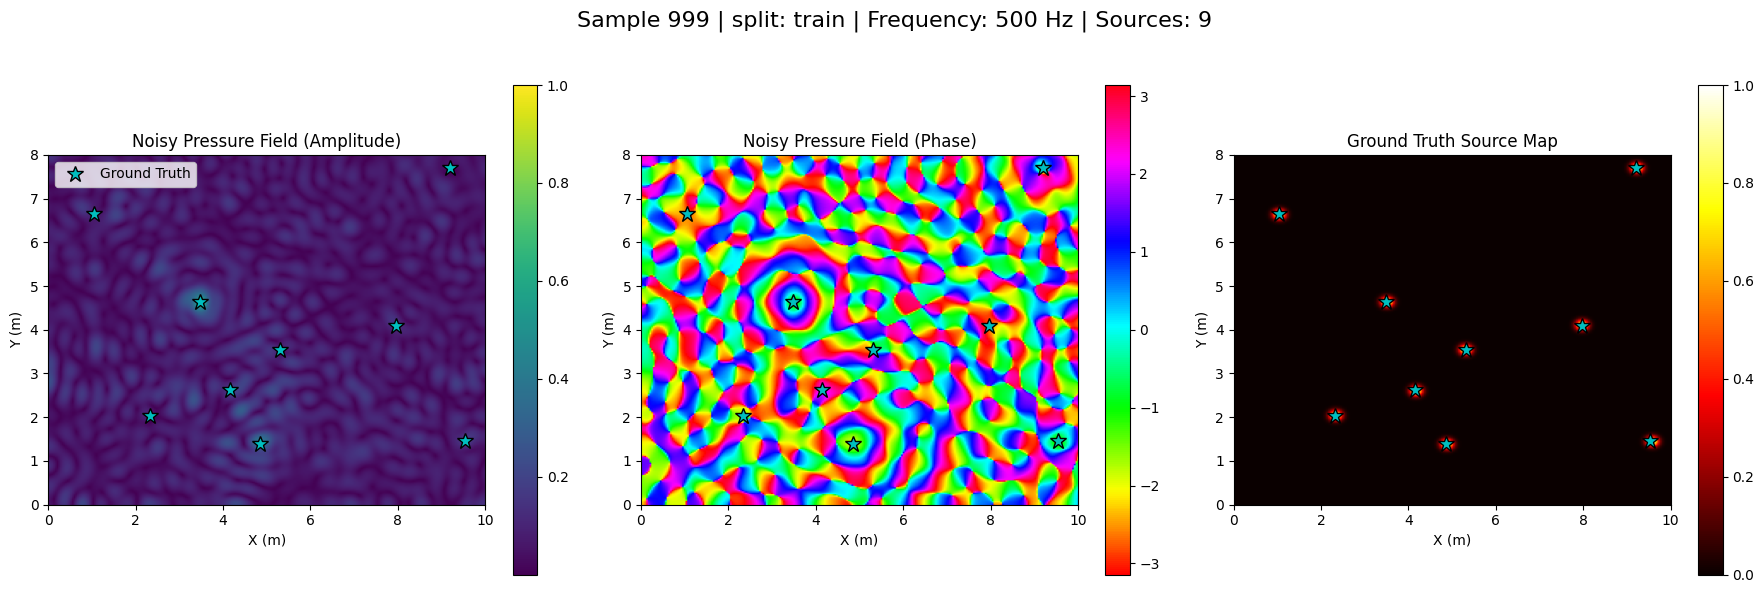

In [23]:
from acoustic_loc.utils import visualize_dataset_sample

# Возьми уже готовый датасет из H5
project_dir = "C:/GitProject/acoustic-source-localization"

# Например, визуализируем несколько сэмплов
for sid in [1, 2, 100, 500, 999]:
    visualize_dataset_sample(
        project_dir=project_dir,
        sample_id=sid,
        split=None,            # autodetect train/val/test
        cmap_field="viridis",
        cmap_phase="hsv",
        cmap_smap="hot",
        figsize=(18, 6),
    )


C:\Users\aboba\AppData\Local\Temp\ipykernel_4368\823198563.py:84: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig2.tight_layout()


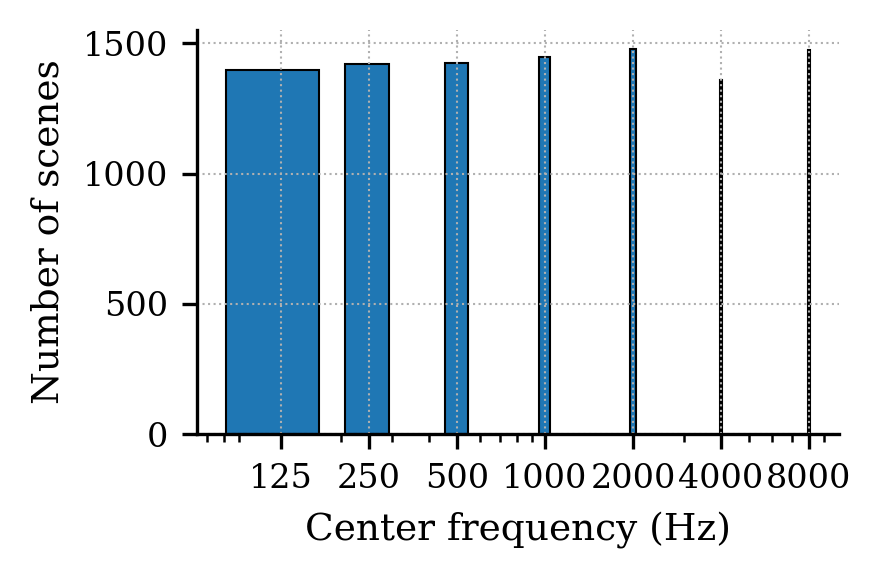

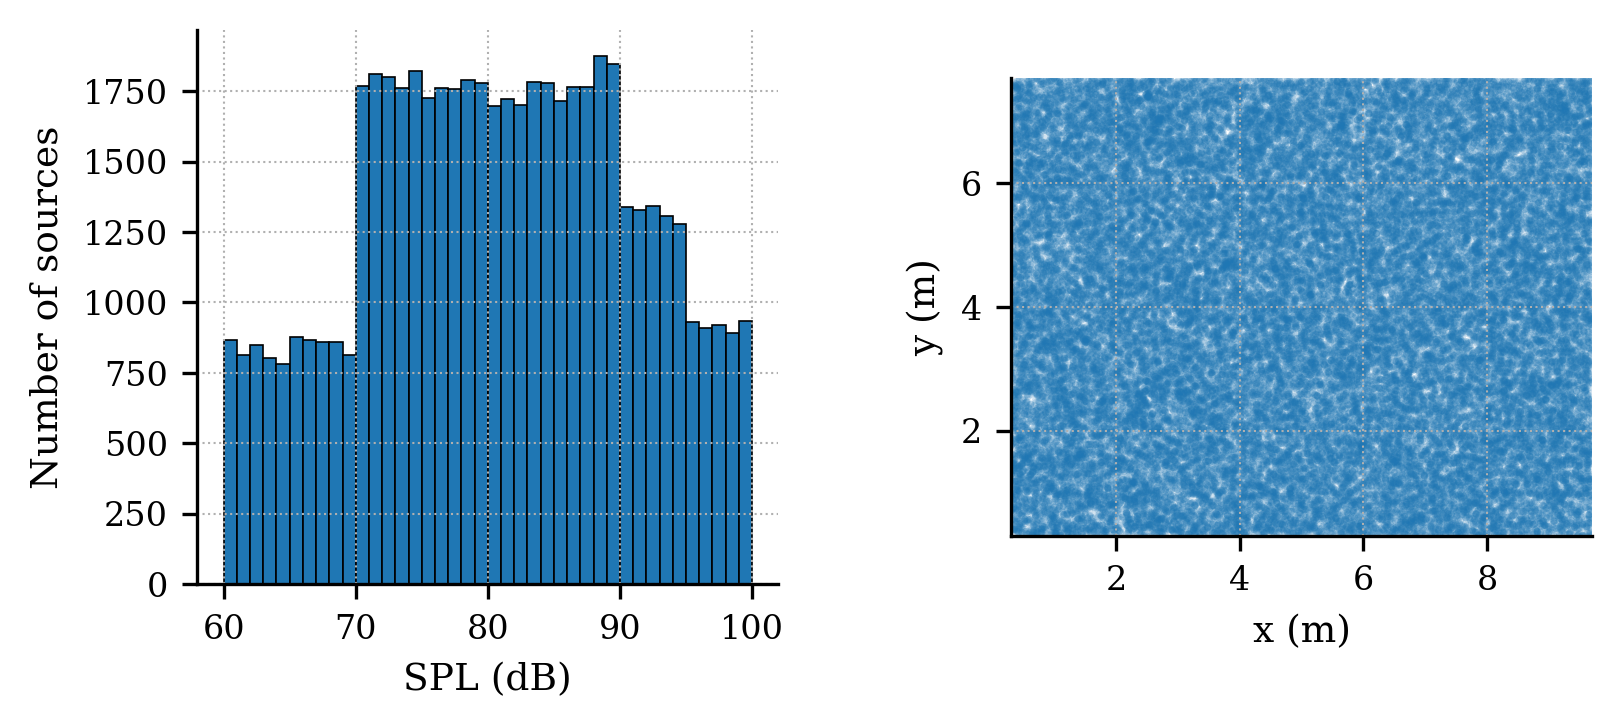

In [ ]:
import json
import numpy as np
from pathlib import Path
import glob
import matplotlib as mpl
import matplotlib.pyplot as plt

# ------------------ общие настройки стиля ------------------
mpl.rcParams.update({
    "font.family": "serif",
    "font.size": 9,
    "axes.labelsize": 9,
    "axes.titlesize": 9,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "legend.fontsize": 8,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.grid": True,
    "grid.linestyle": ":",
    "grid.linewidth": 0.5,
    "figure.dpi": 300
})

json_files = glob.glob("../data/metadata/json/sample_*_info.json")

freqs = []
spls = []
xs, ys, zs = [], [], []

for path in json_files:
    with open(path, "r", encoding="utf-8") as f:
        meta = json.load(f)
    freqs.append(meta["frequency"])
    for s in meta["sources"]:
        spls.append(s["spl_db"])
        xs.append(s["position"]["x"])
        ys.append(s["position"]["y"])
        zs.append(s["position"]["z"])

freqs = np.array(freqs)
spls = np.array(spls)
xs = np.array(xs)
ys = np.array(ys)
zs = np.array(zs)

unique_freqs, counts_freq = np.unique(freqs, return_counts=True)

# --------- 1) Распределение центральных частот ----------------
fig1, ax1 = plt.subplots(figsize=(3.0, 2.0))  # ~одна колонка IEEE
bar_width = 0.7 * np.min(np.diff(unique_freqs))  # чуть уже, чем расстояние между частотами

ax1.bar(unique_freqs, counts_freq, width=bar_width, edgecolor="black", linewidth=0.5)
ax1.set_xlabel("Center frequency (Hz)")
ax1.set_ylabel("Number of scenes")
ax1.set_xscale("log")                  # для октавных частот лог‑шкала лучше читается
ax1.set_xticks(unique_freqs)
ax1.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())  # подписи без экспонент
ax1.set_ylim(bottom=0)

fig1.tight_layout()
fig1.savefig("freq_distribution.pdf", bbox_inches="tight")

# --------- 2) SPL + расположение источников в одной фигуре ----
fig2, (ax2, ax3) = plt.subplots(
    1, 2,
    figsize=(6.0, 2.4),  # две колонки или широкая одна
    gridspec_kw={"wspace": 0.4}
)

# SPL
ax2.hist(spls, bins=40, color="tab:blue", edgecolor="black", linewidth=0.4)
ax2.set_xlabel("SPL (dB)")
ax2.set_ylabel("Number of sources")

# Расположение источников (x–y)
ax3.scatter(xs, ys, s=3, alpha=0.2, color="tab:blue", edgecolors="none")
ax3.set_xlabel("x (m)")
ax3.set_ylabel("y (m)")
ax3.set_xlim(xs.min(), xs.max())
ax3.set_ylim(ys.min(), ys.max())
ax3.set_aspect("equal", adjustable="box")

fig2.tight_layout()
fig2.savefig("spl_and_positions.pdf", bbox_inches="tight")

plt.show()


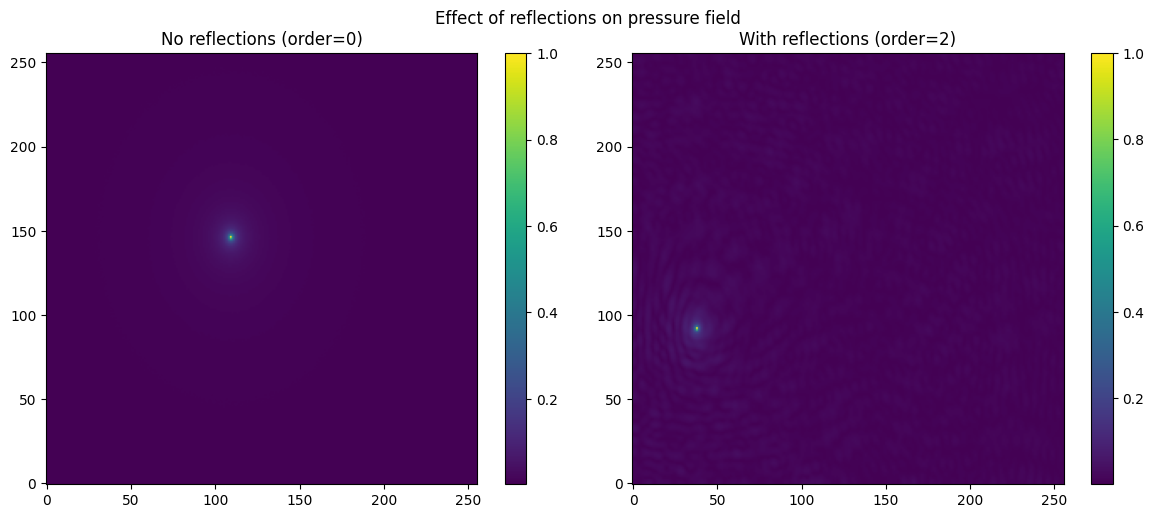

In [25]:
# один и тот же источник, но с max_image_order=0 и 2
sim_no_refl = AcousticSimulator(cfg)
sim_no_refl.max_image_order = 0
p0, s0, _ = sim_no_refl.generate_scene()

sim_refl = AcousticSimulator(cfg)
sim_refl.max_image_order = 2
p2, s2, _ = sim_refl.generate_scene()

mag0 = np.abs(p0)
mag2 = np.abs(p2)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
im0 = axes[0].imshow(mag0.T / mag0.max(), origin="lower", cmap="viridis")
axes[0].set_title("No reflections (order=0)")
plt.colorbar(im0, ax=axes[0])

im1 = axes[1].imshow(mag2.T / mag2.max(), origin="lower", cmap="viridis")
axes[1].set_title("With reflections (order=2)")
plt.colorbar(im1, ax=axes[1])

plt.suptitle("Effect of reflections on pressure field")
plt.tight_layout()
plt.show()
